In [1]:
cd /Users/karolinegriesbach/Documents/Innkeepr/Git/consumption-based-costs/

/Users/karolinegriesbach/Documents/Innkeepr/Git/consumption-based-costs


/Users/karolinegriesbach/.local/share/virtualenvs/consumption-based-costs-wGvc2ut4/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import re
import json
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from src.utils.accounts import sanitize_account_name
from src.utils.innkeepr_api import call_api_with_service_token, send_to_innkeepr_api_paginated
from src.utils.constants import return_api_url_innkeepr
from src.utils.github_connection import read_yaml_from_github
from src.utils.databricks_pp import handle_databricks_cost
from src.utils.azure_pp import handle_azure_costs
from src.utils.aws_pp import handle_aws_costs
from src.utils.stackit_pp import stack_pp

# Define Variables

In [3]:
from_date = "2024-01-01"
to_date="2025-06-12"
timestamp = "2025-06-13 11:40:40.049356"
path_to_dir = f"/Users/karolinegriesbach/Documents/Innkeepr/Git/consumption-based-costs/data/{from_date}_to_{to_date}/{timestamp}/"
path_to_data=f"{path_to_dir}final_costs_with_azure_and_aws_and_db_{from_date}_{to_date}.csv"
path_to_save = f"/Users/karolinegriesbach/Documents/Innkeepr/Git/consumption-based-costs/data/{from_date}_to_{to_date}/targeting_and_retraining/"
url = return_api_url_innkeepr()
stackit_cost_handling = {
    # "start": "2024-11-11",
    "exlude_date_ranges": [
        {
            "start": "2024-12-22",
            "end" : "2025-01-03",
        }
    ],
    "start":"2025-02-09" # davor keine eindeutige Kostenzuordnung zw. azure und stackit möglich in den Zeitspannen: 12.11.24 - 19.11.24, 20.12.24-21.12.24, 04.01.25-06.01.25, 10.01.25-12.01.25, 07.02.25 - 08.02.25
}

In [4]:
os.makedirs(path_to_save, exist_ok=True)

# Load Data

In [5]:
df = pd.read_csv(path_to_data)
df = df[[col for col in df.columns if "Unnamed" not in col]]
df

/var/folders/yg/6h14_gl52p7_rhsrqbdjv0br0000gn/T/ipykernel_27718/412615877.py:1: DtypeWarning: Columns (4,5,6,7,8,9,11,12,13,14,15,17,18,19,20,22,23,24,27,28,31,38,39,40,41,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_data)


,Deployments,tenant,deployment_node_name,audience,schedule,use_conversion_table_targeting,max_model_age_in_days,node_retraining_reset,Prefect_Deployments,timestamp,...,total_charge_of_serviceName,count_services,charge_by_service,effective_price,billing_currency,resource_id,resource_name,resource_group,amortized_cost,cluster_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.188056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,retraining,asambeauty,16cpu256gib,6687daf21767991e3bdfb414,16 2 * * *,NaN,14.0,30cpu476gib,retraining,2024-10-16 00:36:36.760786,...,18.846250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46.068611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.256667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.632778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,USD,NaN,NaN,node_types,NaN,NaN
125197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,USD,NaN,NaN,node_types,NaN,NaN
125198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,USD,NaN,NaN,node_types,NaN,NaN
125199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,USD,NaN,NaN,node_types,NaN,NaN


In [6]:
df["node_name"]

0         16cpu256gib
1         16cpu256gib
2         16cpu256gib
3         16cpu256gib
4         16cpu256gib
             ...     
125196            NaN
125197            NaN
125198            NaN
125199            NaN
125200            NaN
Name: node_name, Length: 125201, dtype: object

In [7]:
df = stack_pp(df)
df

Service: General Purpose Server-g1.4-EU01
Service: General Purpose Server-g1.1-EU01
Service: Compute Optimized Server-c1.2-EU01
Service: Tiny Server-t1.2-EU01


,Deployments,tenant,deployment_node_name,audience,schedule,use_conversion_table_targeting,max_model_age_in_days,node_retraining_reset,Prefect_Deployments,timestamp,...,total_charge_of_serviceName,count_services,charge_by_service,effective_price,billing_currency,resource_id,resource_name,resource_group,amortized_cost,cluster_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.188056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,retraining,asambeauty,16cpu256gib,6687daf21767991e3bdfb414,16 2 * * *,NaN,14.0,30cpu476gib,retraining,2024-10-16 00:36:36.760786,...,18.846250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46.068611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.256667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,58.632778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,USD,NaN,NaN,node_types,NaN,NaN
125197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,USD,NaN,NaN,node_types,NaN,NaN
125198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,USD,NaN,NaN,node_types,NaN,NaN
125199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,USD,NaN,NaN,node_types,NaN,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125201 entries, 0 to 125200
Data columns (total 40 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Deployments                     16818 non-null   object 
 1   tenant                          33598 non-null   object 
 2   deployment_node_name            6841 non-null    object 
 3   audience                        11561 non-null   object 
 4   schedule                        11561 non-null   object 
 5   use_conversion_table_targeting  9010 non-null    object 
 6   max_model_age_in_days           1584 non-null    float64
 7   node_retraining_reset           760 non-null     object 
 8   Prefect_Deployments             36445 non-null   object 
 9   timestamp                       35826 non-null   object 
 10  audience_id                     27542 non-null   object 
 11  account                         35826 non-null   object 
 12  duration        

In [9]:
df["Prefect_Deployments"] = df["Prefect_Deployments"].replace("retrainng", "retraining")
df["Prefect_Deployments"].value_counts()

Prefect_Deployments
targeting                       23470
etlFlow                          6019
retraining                       3989
genPropConversionTable           1694
stackit_default_servers           739
updateConversionTable             450
googleConversionUpdate             78
TEST-googleConversionUpdate         3
TEST-k8-targeting                   2
TEST-update-conversion-table        1
Name: count, dtype: int64

In [10]:
df["Prefect_Deployments"].value_counts()

Prefect_Deployments
targeting                       23470
etlFlow                          6019
retraining                       3989
genPropConversionTable           1694
stackit_default_servers           739
updateConversionTable             450
googleConversionUpdate             78
TEST-googleConversionUpdate         3
TEST-k8-targeting                   2
TEST-update-conversion-table        1
Name: count, dtype: int64

# Filter Data
Filter data for targeting runs only using Deployments and Prefect_Deployments

In [11]:
# get stackIT costs via Prefect_Deployments
targeting_and_retraining_runs = df[(df["Deployments"]=="targeting")|(df["Prefect_Deployments"]=="targeting")|(df["Deployments"]=="retraining")|(df["Prefect_Deployments"]=="retraining")|(df["Deployments"]=="googleConversionUpdate")|(df["Prefect_Deployments"]=="googleConversionUpdate")]
# Bug in cost extractor: "retrainng" instead of "retraining" (behoben)
targeting_and_retraining_runs

,Deployments,tenant,deployment_node_name,audience,schedule,use_conversion_table_targeting,max_model_age_in_days,node_retraining_reset,Prefect_Deployments,timestamp,...,total_charge_of_serviceName,count_services,charge_by_service,effective_price,billing_currency,resource_id,resource_name,resource_group,amortized_cost,cluster_id
1,retraining,asambeauty,16cpu256gib,6687daf21767991e3bdfb414,16 2 * * *,NaN,14.0,30cpu476gib,retraining,2024-10-16 00:36:36.760786,...,18.846250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,retraining,asambeauty,16cpu256gib,6687da6e1767991e3bdfa9d8,15 5 * * *,NaN,14.0,30cpu476gib,retraining,2024-10-22 03:35:35.979026,...,50.256667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,retraining,asambeauty,16cpu256gib,670509c46b67f0eede5ea371,56 3 * * *,NaN,14.0,30cpu476gib,retraining,2024-10-22 04:22:50.831826,...,50.256667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,retraining,asambeauty,16cpu256gib,6617da9c01c2ab3bd12c63cb,47 3 * * *,NaN,14.0,30cpu476gib,retraining,2024-10-23 02:39:15.536370,...,50.256667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,retraining,asambeauty,16cpu256gib,6687da6e1767991e3bdfa9d8,15 5 * * *,NaN,14.0,30cpu476gib,retraining,2024-10-23 03:38:28.244593,...,50.256667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,googleConversionUpdate,2025-05-22 23:22:15.369427,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,googleConversionUpdate,2025-05-25 12:14:37.767248,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,googleConversionUpdate,2025-05-25 12:13:52.247539,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,googleConversionUpdate,2025-05-26 07:03:15.630586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
targeting_and_retraining_runs["Prefect_Deployments"].value_counts()

Prefect_Deployments
targeting                 23470
retraining                 3989
googleConversionUpdate       78
Name: count, dtype: int64

# Historical count of targeting runs and prefect runs

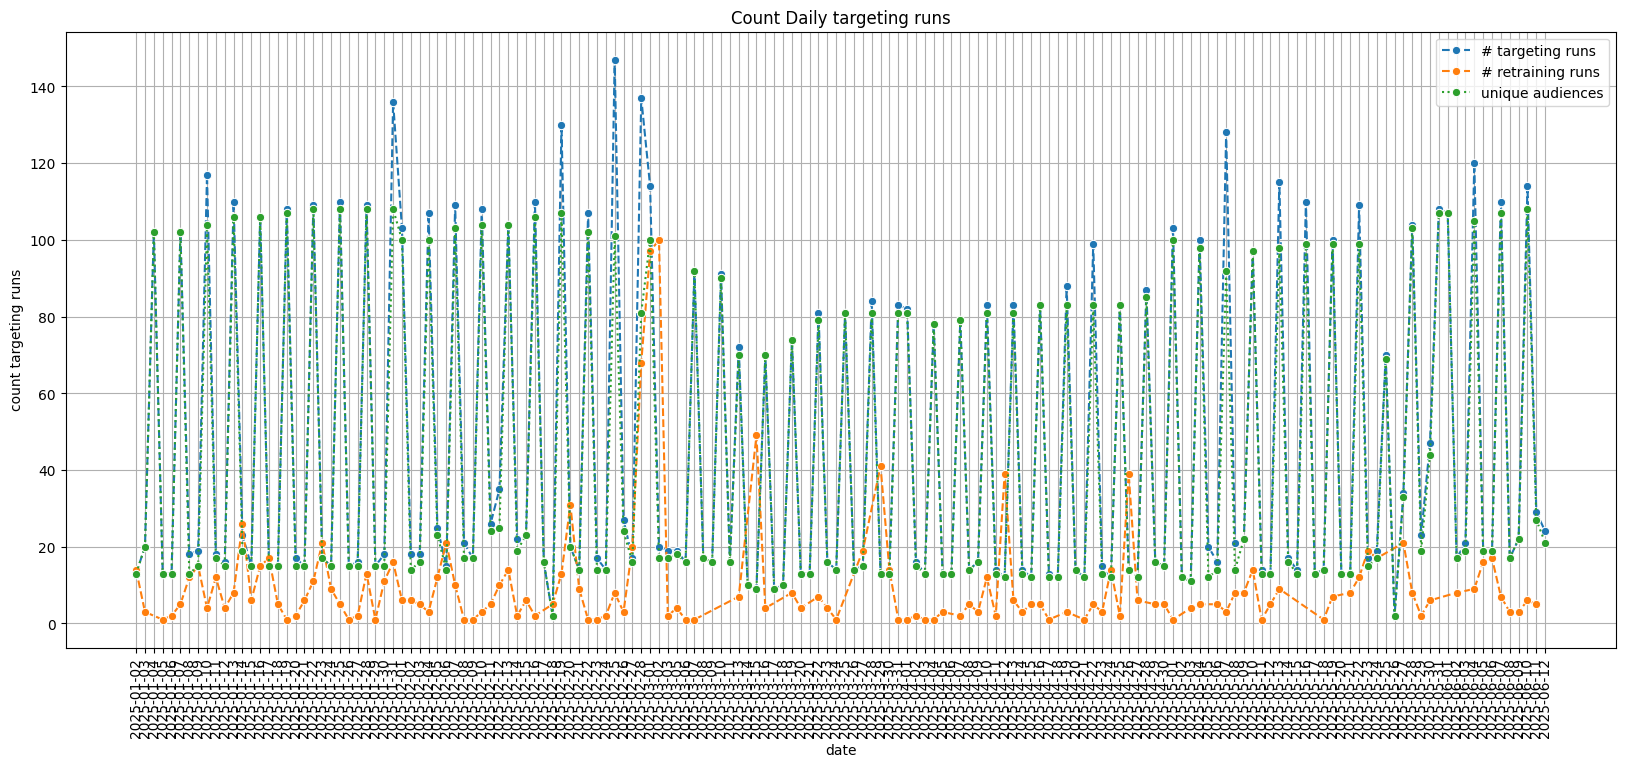

In [13]:
targeting_runs = targeting_and_retraining_runs[targeting_and_retraining_runs["Prefect_Deployments"]=="targeting"]
retraining_runs = targeting_and_retraining_runs[targeting_and_retraining_runs["Prefect_Deployments"]=="retraining"]
runs_vc_by_date = targeting_runs.groupby("date")["Prefect_Deployments"].value_counts()
runs_vc_by_date = pd.DataFrame(runs_vc_by_date).reset_index().rename(columns={"count":"count targeting runs"})
runs_vc_by_date_retraining = retraining_runs.groupby("date")["Prefect_Deployments"].value_counts()
runs_vc_by_date_retraining = pd.DataFrame(runs_vc_by_date_retraining).reset_index().rename(columns={"count":"count retraining runs"})
audiences_unique_by_date = targeting_runs.groupby("date")["audience_id"].nunique()
audiences_unique_by_date = pd.DataFrame(audiences_unique_by_date).reset_index()
concat = pd.merge(runs_vc_by_date, audiences_unique_by_date, on="date")
fig = plt.figure(figsize=(20,8))
sns.lineplot(
    x="date",
    y="count targeting runs",
    data=runs_vc_by_date[runs_vc_by_date["date"] > "2025-01-01"],
    marker="o",
    linestyle="--",
    label="# targeting runs"
)
sns.lineplot(
    x="date",
    y="count retraining runs",
    data=runs_vc_by_date_retraining[runs_vc_by_date_retraining["date"] > "2025-01-01"],
    marker="o",
    linestyle="--",
    label="# retraining runs"
)
sns.lineplot(
    x="date",
    y="audience_id",
    data=audiences_unique_by_date[audiences_unique_by_date["date"] > "2025-01-01"],
    marker="o",
    linestyle=":",
    label="unique audiences"
)
plt.title("Count Daily targeting runs")
plt.xticks(rotation=90)
plt.grid(True)

# Check Data Completion for node types, date and costs

In [14]:
print(len(targeting_and_retraining_runs))
null_values = targeting_and_retraining_runs[["node_name","date","charge","machine.type","audience_id","duration","total_charge_of_serviceName","audience"]].isnull().sum()
null_values = pd.DataFrame(null_values).rename(columns={0:"isnull"})
null_values["percentage_of_isnull"] = null_values["isnull"]/len(targeting_and_retraining_runs) * 100
null_values.sort_values(by="isnull")

27537


,isnull,percentage_of_isnull
date,0,0.000000
audience_id,0,0.000000
duration,0,0.000000
audience,15976,58.016487
node_name,24939,90.565421
charge,25579,92.889567
machine.type,25579,92.889567
total_charge_of_serviceName,25579,92.889567


## Handling Missing Data
- fehlend node_names mit existing node_names anreichern via targeting audience
- fehlende Kosten über node_names und runtime anreichern
- charges per targeting run erst ab dm 26.05.2025


In [15]:
targeting_and_retraining_runs[["Prefect_Deployments","audience_id","date","charge","node_name","machine.type"]]

,Prefect_Deployments,audience_id,date,charge,node_name,machine.type
1,retraining,6687daf21767991e3bdfb414,2024-10-16,18.846250,16cpu256gib,b1a.16d
7,retraining,6687da6e1767991e3bdfa9d8,2024-10-22,12.953533,16cpu256gib,b1a.16d
8,retraining,670509c46b67f0eede5ea371,2024-10-22,37.303132,16cpu256gib,b1a.16d
9,retraining,6617da9c01c2ab3bd12c63cb,2024-10-23,37.379716,16cpu256gib,b1a.16d
10,retraining,6687da6e1767991e3bdfa9d8,2024-10-23,12.876951,16cpu256gib,b1a.16d
...,...,...,...,...,...,...
38624,googleConversionUpdate,67c54aca23595a274477154e,2025-05-22,NaN,NaN,NaN
38651,googleConversionUpdate,67acb5b917e4d31f493abf25,2025-05-25,NaN,NaN,NaN
38652,googleConversionUpdate,67c54aca23595a274477154e,2025-05-25,NaN,NaN,NaN
38654,googleConversionUpdate,67acb5b917e4d31f493abf25,2025-05-26,NaN,NaN,NaN


## Query models for all active accounts

In [16]:
# query models to map audience node_name with targetingOutlook (is one of the main parameter to choose the node size)
try:
    models = pd.read_csv(f"{path_to_save}all_models.csv")
    with open(f"{path_to_save}ignore_tenants.json", "r") as f:
        ignore_tenants = json.load(f)
except FileNotFoundError:
    print("query data")
    models=pd.DataFrame()
    #min_date = targeting_and_retraining_runs["date"].min()
    #min_date = (pd.to_datetime(min_date)-timedelta(days=60)).strftime("%Y-%m-%d")
    ignore_tenants = []
    accounts = call_api_with_service_token(f"{url}/core/accounts/query", {}, logging)
    for tenant in targeting_and_retraining_runs["tenant"].unique():
        print(tenant)
        account_id = [acc["id"] for acc in accounts if sanitize_account_name(acc["name"])==tenant]
        if len(account_id) > 1:
            raise Exception(f"More than one account with name {tenant}")
        if len(account_id) == 0:
            print(f"Tenant {tenant} not found in accounts")
            ignore_tenants.append(tenant)
            continue
        account_id = account_id[0]
        temp_models = send_to_innkeepr_api_paginated(
            f"{url}/models/query",
            account_id,
            {},
            logging
        )
        temp_models = pd.json_normalize(temp_models)
        if len(temp_models) == 0:
            print(f"No models found for tenant {tenant}")
            ignore_tenants.append(tenant)
            continue
        #temp_models = temp_models[temp_models["created"]>=min_date]
        models = pd.concat([models, temp_models])
    print(models.shape)
    missing_audiences = targeting_runs[targeting_runs["tenant"].isin(ignore_tenants)==False]
    missing_audiences = missing_audiences[missing_audiences["audience_id"].isin(models["audience"].unique())==False]
    if missing_audiences.empty == False:
        print(f"Missing {len(missing_audiences)} models")
        print(missing_audiences[["tenant","audience_id"]].drop_duplicates())
    models.to_csv(f"{path_to_save}all_models.csv")
    with open(f"{path_to_save}ignore_tenants.json", "w") as f:
        json.dump(list(ignore_tenants), f)
models

,Unnamed: 0,id,created,path,audience,treatment,goal,targetingOutlookDays,trainingOutlookDays,f1Score,audienceSizePercentage,treatmentSessionCount,type,audienceSize,outlook,conversionLag,manualRetrainReason
0,0,66a4676ddc89c1900b14b906,2024-07-27T03:20:13.127Z,asambeauty-aud-65c0f44bf2e2b9b5a9bab145/2024-0...,65c0f44bf2e2b9b5a9bab145,"['65b1b4eed3c557379810c8c2', '65b1b4eed3c55737...",65ae65e92989649becfd8cf6,23.0,NaN,0.55,NaN,127724.0,causal,150000.0,NaN,NaN,NaN
1,1,66a981af7b71545fb02be286,2024-07-31T00:13:35.669Z,asambeauty-conversion-65ae65e92989649becfd8cf6...,668d44dc1767991e3b3c3fef,[],65ae65e92989649becfd8cf6,90.0,NaN,0.82,NaN,11455.0,conversion,150000.0,NaN,NaN,NaN
2,2,66ad8e53104f9bacb5495ce8,2024-08-03T01:56:35.836Z,asambeauty-conversion-65ae65e92989649becfd8cf6...,6617a6ed01c2ab3bd127f8c5,[],65ae65e92989649becfd8cf6,90.0,NaN,0.84,NaN,0.0,conversion,150000.0,NaN,NaN,NaN
3,3,66b57753b599ea1467b95c75,2024-08-09T01:56:35.572Z,asambeauty-conversion-65ae65e92989649becfd8cf6...,6617a6ed01c2ab3bd127f8c5,[],65ae65e92989649becfd8cf6,90.0,NaN,0.84,NaN,0.0,conversion,150000.0,NaN,NaN,NaN
4,4,67243467f54847c02c17bb4d,2024-11-01T01:52:39.656Z,asambeauty-aud-66c5f8db781b51d399748172/2024-1...,66c5f8db781b51d399748172,"['65b1b4eed3c557379810c8e5', '65b1b4eed3c55737...",65ae65e92989649becfd8cf6,30.0,NaN,0.74,0.5,77994.0,causal,150000.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5517,291,67c3c27e640e06a4e707e607,2025-03-02T02:29:18.603Z,paulvalentine-conversion-669d6580c77d9922edbfa...,66be1d01781b51d399a63d36,[],669d6580c77d9922edbfa545,30.0,NaN,0.90,0.5,0.0,conversion,150000.0,NaN,180.0,NaN
5518,292,67c3c8687650bd81c3e8a327,2025-03-02T02:54:31.959Z,paulvalentine-conversion-669d6580c77d9922edbfa...,670921946b67f0eeded38450,[],669d6580c77d9922edbfa545,30.0,NaN,0.90,0.5,0.0,conversion,150000.0,NaN,NaN,NaN
5519,293,67c3ca4360c56cf0da9b3114,2025-03-02T03:02:26.930Z,paulvalentine-conversion-669d6580c77d9922edbfa...,66be1d6f781b51d399a64995,[],669d6580c77d9922edbfa545,30.0,NaN,0.90,0.5,0.0,conversion,150000.0,NaN,NaN,NaN
5520,294,67c3d26c640e06a4e707e60a,2025-03-02T03:37:16.087Z,paulvalentine-conversion-669d6580c77d9922edbfa...,67a4c6e9e9a9d2ef0b863db4,[],669d6580c77d9922edbfa545,30.0,NaN,0.90,0.5,0.0,conversion,150000.0,NaN,180.0,NaN


In [17]:
audiences_in_models_but_not_in_targeting_runs = models[
    (models["audience"].isin(targeting_runs[targeting_runs["tenant"].isin(ignore_tenants)==False]["audience_id"].unique())==False) &
    (models["created"]>=targeting_runs["date"].min())
    ]
if audiences_in_models_but_not_in_targeting_runs.empty == False:
    print(f"Found {len(audiences_in_models_but_not_in_targeting_runs)} models that are not in the targeting runs")
    raise Exception(audiences_in_models_but_not_in_targeting_runs[["audience","path","created"]])

Found 3 models that are not in the targeting runs


Exception:                       audience  \
1564  65fb0acf15c25acc11bebf44   
1607  65fb0a7c15c25acc11beb553   
1960  65fb0b0b15c25acc11bec741   

                                                   path  \
1564  rosental-conversion-63e61e29bfc19074664d8a32/2...   
1607  rosental-conversion-63e61e29bfc19074664d8a32/2...   
1960  rosental-conversion-63e61e29bfc19074664d8a32/2...   

                       created  
1564  2024-03-21T05:14:01.146Z  
1607  2024-03-21T02:55:02.651Z  
1960  2024-03-21T04:31:57.849Z  

## Merge Models and Targeting Runs by considering date and targetingOutlookDays

In [18]:
models = models[["audience","created","targetingOutlookDays"]]
models.head()

,audience,created,targetingOutlookDays
0,65c0f44bf2e2b9b5a9bab145,2024-07-27T03:20:13.127Z,23.0
1,668d44dc1767991e3b3c3fef,2024-07-31T00:13:35.669Z,90.0
2,6617a6ed01c2ab3bd127f8c5,2024-08-03T01:56:35.836Z,90.0
3,6617a6ed01c2ab3bd127f8c5,2024-08-09T01:56:35.572Z,90.0
4,66c5f8db781b51d399748172,2024-11-01T01:52:39.656Z,30.0


In [19]:
targeting_and_retraining_runs["tenant"] = np.where(
    targeting_and_retraining_runs["tenant"].isnull(),
    targeting_and_retraining_runs["account"].str.replace(" ","").str.lower(),
    targeting_and_retraining_runs["tenant"]
)

/var/folders/yg/6h14_gl52p7_rhsrqbdjv0br0000gn/T/ipykernel_27718/838350266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targeting_and_retraining_runs["tenant"] = np.where(


In [20]:
models = models.rename(columns={"audience":"audience_id","created":"created_data_model_for_testing"})
# Filter data_model_for_testing to get the most recent model for each audience before the date in data_for_testing
print(f"targeting_and_retraining_runs = {len(targeting_and_retraining_runs)}")
merged_targeting_runs_with_models = pd.merge(targeting_and_retraining_runs, models, on=['audience_id'], how="left")#suffixes=('_data_for_testing', '_data_model_for_testing'))
# macht data where the model.created < data.timestamp
merged_targeting_runs_with_models_with_previous_models = merged_targeting_runs_with_models[pd.to_datetime(merged_targeting_runs_with_models['created_data_model_for_testing'],utc=True) <= pd.to_datetime(merged_targeting_runs_with_models['timestamp'],utc=True)]
merged_targeting_runs_with_models_with_previous_models = merged_targeting_runs_with_models_with_previous_models.sort_values(by='created_data_model_for_testing', ascending=False).drop_duplicates(subset=['Prefect_Deployments','tenant','audience_id','timestamp','node_name'], keep='first')
print(f"merged_targeting_runs_with_models_with_previous_models = {len(merged_targeting_runs_with_models_with_previous_models)}")
# get data where data.timestamp does not have a matching model
merged_targeting_runs_with_models_without_previous_models = models.groupby("audience_id")["created_data_model_for_testing"].min()
merged_targeting_runs_with_models_without_previous_models = pd.DataFrame(merged_targeting_runs_with_models_without_previous_models).reset_index()
merged_targeting_runs_with_models_without_previous_models = pd.merge(targeting_and_retraining_runs, merged_targeting_runs_with_models_without_previous_models, on="audience_id")
merged_targeting_runs_with_models_without_previous_models = merged_targeting_runs_with_models_without_previous_models[pd.to_datetime(merged_targeting_runs_with_models_without_previous_models['timestamp'],utc=True) <= pd.to_datetime(merged_targeting_runs_with_models_without_previous_models['created_data_model_for_testing'],utc=True)]
print(f"merged_targeting_runs_with_models_without_previous_models = {len(merged_targeting_runs_with_models_without_previous_models)}")
# get data with null models
considered_audiences = merged_targeting_runs_with_models_with_previous_models["audience_id"].unique().tolist() + merged_targeting_runs_with_models_without_previous_models["audience_id"].unique().tolist()
merged_targeting_runs_with_models_null_models = merged_targeting_runs_with_models[
    (merged_targeting_runs_with_models["audience_id"].isin(considered_audiences) == False)]
merged_targeting_runs_with_models_null_models = merged_targeting_runs_with_models_null_models[merged_targeting_runs_with_models_null_models["tenant"].isin(ignore_tenants)==False]
print(f"merged_targeting_runs_with_models_null_models = {len(merged_targeting_runs_with_models_null_models)}")
# concate data
merged_targeting_runs_with_models = pd.concat([merged_targeting_runs_with_models_with_previous_models, merged_targeting_runs_with_models_without_previous_models,merged_targeting_runs_with_models_null_models])
merged_targeting_runs_with_models = merged_targeting_runs_with_models.reset_index(drop=True)
print(f"merged_targeting_runs_with_models = {len(merged_targeting_runs_with_models)}")
targeting_runs_to_compare = targeting_and_retraining_runs[targeting_and_retraining_runs["tenant"].isin(ignore_tenants)==False]
if len(merged_targeting_runs_with_models) != len(targeting_runs_to_compare):
    raise Exception(f"Unequal length targeting_runs_to_compare {len(targeting_runs_to_compare)} vs. merged {len(merged_targeting_runs_with_models)}")
merged_targeting_runs_with_models[["tenant","audience_id","date","node_name","timestamp","created_data_model_for_testing","targetingOutlookDays"]]

targeting_and_retraining_runs = 27537
merged_targeting_runs_with_models_with_previous_models = 23623
merged_targeting_runs_with_models_without_previous_models = 95
merged_targeting_runs_with_models_null_models = 4
merged_targeting_runs_with_models = 23722


,tenant,audience_id,date,node_name,timestamp,created_data_model_for_testing,targetingOutlookDays
0,nikin,6847ea3657bdaeb51ed9e87d,2025-06-12,4cpu8gib,2025-06-12 23:52:15.790940,2025-06-12T12:38:58.503Z,90.0
1,asambeauty,6687da6e1767991e3bdfa9d8,2025-06-11,8cpu128gib,2025-06-11 11:07:07.871896,2025-06-11T10:25:00.488Z,90.0
2,nikin,6847ea3657bdaeb51ed9e87d,2025-06-12,4cpu8gib,2025-06-12 09:16:50.438835,2025-06-11T04:14:58.503Z,90.0
3,nikin,6847ea3657bdaeb51ed9e87d,2025-06-11,4cpu8gib,2025-06-11 23:51:47.688281,2025-06-11T04:14:58.503Z,90.0
4,nikin,6847ea3657bdaeb51ed9e87d,2025-06-11,medium32g,2025-06-11 04:17:46.995995,2025-06-11T04:14:58.503Z,90.0
...,...,...,...,...,...,...,...
23717,rosental,679d1e91e9a9d2ef0bbedd64,2025-02-02,NaN,2025-02-02 06:00:15.712632,2025-02-03T02:58:05.926Z,NaN
23718,rosental,671cfe772c5ade4568d5bf1f,2024-10-26,NaN,2024-10-26 15:29:54.020967,NaN,NaN
23719,rosental,671cfe772c5ade4568d5bf1f,2024-10-27,NaN,2024-10-27 06:17:37.428091,NaN,NaN
23720,rosental,671cfe772c5ade4568d5bf1f,2024-10-27,NaN,2024-10-27 09:42:12.147160,NaN,NaN


In [21]:
# if dataframe does not match lenght - check why
vc_before = pd.DataFrame(targeting_and_retraining_runs[targeting_and_retraining_runs["tenant"].isin(ignore_tenants)==False].groupby(by=["Prefect_Deployments","audience_id"])["date"].value_counts()).reset_index().sort_values(by=["audience_id","date"], ascending=False).reset_index(drop=True)
vc_after = pd.DataFrame(merged_targeting_runs_with_models.groupby(by=["Prefect_Deployments","audience_id"])["date"].value_counts()).reset_index().sort_values(by=["audience_id","date"], ascending=False).reset_index(drop=True)
if vc_after.equals(vc_before):
    print("fine")
else:
    print("not fine")

fine


# Extract node gb size and cpu

In [22]:
def extract_node_parameters(string,node_spec=None):
    #print(string)
    if isinstance(string, str) == False:
        #print(f"String is not given")
        return None
    if "medium32g" in string:
        if node_spec == "cpu":
            return None
        elif node_spec == "gb":
            return 32
        else:
            raise ValueError(f"Node spec needs to be cpu or gb")
    if "x2large" in string:
        if node_spec == "cpu":
            return 29
        elif node_spec == "gb":
            return 350
        else:
            raise ValueError(f"Node spec needs to be cpu or gb")
    if "small" in string:
        if node_spec == "cpu":
            return 3
        elif node_spec == "gb":
            return 4
        else:
            raise ValueError(f"Node spec needs to be cpu or gb")
    if "xlarge" in string:
        if node_spec == "cpu":
            return 7
        elif node_spec == "gb":
            return 110
        else:
            raise ValueError(f"Node spec needs to be cpu or gb")
    if "medium64g" in string:
        if node_spec == "cpu":
            return 3
        elif node_spec == "gb":
            return 55
        else:
            raise ValueError(f"Node spec needs to be cpu or gb")
    if "x4llarge" in string:
        if node_spec == "cpu":
            return 29
        elif node_spec == "gb":
            return 350
        else:
            raise ValueError(f"Node spec needs to be cpu or gb")
    # match the string for cpu and gb
    match = re.search(r"(\d+)cpu(\d+)gib", string)
    if match is False:
        print(f"No match found for {string}")
        return None
    elif node_spec is None:
        raise ValueError(f"Node spec needs to be cpu or gb")
    elif node_spec == "cpu":
        return int(match.group(1))
    elif node_spec == "gb":
        return int(match.group(2))
    else:
        raise ValueError(f"Node spec needs to be cpu or gb")


In [23]:
merged_targeting_runs_with_models["node_gb"] = merged_targeting_runs_with_models["node_name"].apply(lambda x: extract_node_parameters(x,node_spec="gb"))
merged_targeting_runs_with_models["node_cpu"] = merged_targeting_runs_with_models["node_name"].apply(lambda x: extract_node_parameters(x,node_spec="cpu"))
merged_targeting_runs_with_models[["tenant","audience_id","node_name","timestamp","targetingOutlookDays","node_gb","node_cpu"]]

,tenant,audience_id,node_name,timestamp,targetingOutlookDays,node_gb,node_cpu
0,nikin,6847ea3657bdaeb51ed9e87d,4cpu8gib,2025-06-12 23:52:15.790940,90.0,8.0,4.0
1,asambeauty,6687da6e1767991e3bdfa9d8,8cpu128gib,2025-06-11 11:07:07.871896,90.0,128.0,8.0
2,nikin,6847ea3657bdaeb51ed9e87d,4cpu8gib,2025-06-12 09:16:50.438835,90.0,8.0,4.0
3,nikin,6847ea3657bdaeb51ed9e87d,4cpu8gib,2025-06-11 23:51:47.688281,90.0,8.0,4.0
4,nikin,6847ea3657bdaeb51ed9e87d,medium32g,2025-06-11 04:17:46.995995,90.0,32.0,NaN
...,...,...,...,...,...,...,...
23717,rosental,679d1e91e9a9d2ef0bbedd64,NaN,2025-02-02 06:00:15.712632,NaN,NaN,NaN
23718,rosental,671cfe772c5ade4568d5bf1f,NaN,2024-10-26 15:29:54.020967,NaN,NaN,NaN
23719,rosental,671cfe772c5ade4568d5bf1f,NaN,2024-10-27 06:17:37.428091,NaN,NaN,NaN
23720,rosental,671cfe772c5ade4568d5bf1f,NaN,2024-10-27 09:42:12.147160,NaN,NaN,NaN


## Add missing node sizes via current node size mapping
- needs a long time (to speed it up - get audiences with one specification and just iterate over audiences with several specifications)

In [24]:
node_size_mapping_with_size = merged_targeting_runs_with_models.dropna(subset=["node_name"]).drop_duplicates(subset=["Prefect_Deployments","audience_id","node_name","targetingOutlookDays","node_gb","node_cpu"])[["Prefect_Deployments","tenant","audience_id","node_name","node_gb","node_cpu","targetingOutlookDays"]]
vc = pd.DataFrame(node_size_mapping_with_size.groupby("audience_id")["node_name"].nunique()).rename(columns={"node_name":"node_count"})
node_size_mapping_with_size = pd.merge(node_size_mapping_with_size, vc, on="audience_id", how="left")
vc_max = merged_targeting_runs_with_models.groupby(by=["Prefect_Deployments","audience_id","node_name","targetingOutlookDays","node_gb","node_cpu"])["timestamp"].max().reset_index()
node_size_mapping_with_size = pd.merge(node_size_mapping_with_size, vc_max, on=["Prefect_Deployments","audience_id","node_name","targetingOutlookDays","node_gb","node_cpu"], how="left")
for col in node_size_mapping_with_size.columns:
   node_size_mapping_with_size = node_size_mapping_with_size.rename(columns={col: f"{col}_nm"})
node_size_mapping_with_size.sort_values(by=["tenant_nm","audience_id_nm","Prefect_Deployments_nm"])

,Prefect_Deployments_nm,tenant_nm,audience_id_nm,node_name_nm,node_gb_nm,node_cpu_nm,targetingOutlookDays_nm,node_count_nm,timestamp_nm
12,retraining,asambeauty,65c0f024f2e2b9b5a9ba2a4a,x2large,350.0,29.0,90.0,3,2025-06-10 04:13:18.281090
303,retraining,asambeauty,65c0f024f2e2b9b5a9ba2a4a,16cpu256gib,256.0,16.0,90.0,3,2025-05-11 04:12:54.249898
353,retraining,asambeauty,65c0f024f2e2b9b5a9ba2a4a,16cpu256gib,256.0,16.0,60.0,3,2024-06-05 08:07:21.012974
186,targeting,asambeauty,65c0f024f2e2b9b5a9ba2a4a,8cpu128gib,128.0,8.0,90.0,3,2025-06-10 03:49:58.204420
257,retraining,asambeauty,65f301e9f7b4d736196a0ea2,16cpu256gib,256.0,16.0,180.0,2,2025-05-23 01:08:14.630259
...,...,...,...,...,...,...,...,...,...
118,targeting,vioneers,6392fae63ceef43bf3448b98,4cpu8gib,8.0,4.0,720.0,2,2025-06-10 02:15:28.560773
119,retraining,vioneers,63d7b7692393f1ea76dd8531,small,4.0,3.0,720.0,2,2025-06-04 04:10:32.954033
271,retraining,vioneers,63d7b7692393f1ea76dd8531,4cpu8gib,8.0,4.0,720.0,2,2025-05-21 04:12:42.284763
352,retraining,vioneers,63d7b7692393f1ea76dd8531,4cpu8gib,8.0,4.0,NaN,2,NaN


In [25]:
merged_targeting_runs_with_models_with_node_size = pd.merge(
    merged_targeting_runs_with_models,
    node_size_mapping_with_size,
    left_on=["Prefect_Deployments","tenant","targetingOutlookDays"],
    right_on = ["Prefect_Deployments_nm","tenant_nm","targetingOutlookDays_nm"],
    how="left"
)
merged_targeting_runs_with_models_with_node_size[["Prefect_Deployments","tenant","timestamp","audience_id","targetingOutlookDays","node_name","node_gb","node_cpu"]+node_size_mapping_with_size.columns.tolist()].sort_values(by=["tenant","audience_id","Prefect_Deployments"])

,Prefect_Deployments,tenant,timestamp,audience_id,targetingOutlookDays,node_name,node_gb,node_cpu,Prefect_Deployments_nm,tenant_nm,audience_id_nm,node_name_nm,node_gb_nm,node_cpu_nm,targetingOutlookDays_nm,node_count_nm,timestamp_nm
29574,retraining,asambeauty,2025-03-01 02:59:46.046049,65c0f017f2e2b9b5a9ba288f,90.0,NaN,NaN,NaN,retraining,asambeauty,65c0f024f2e2b9b5a9ba2a4a,x2large,350.0,29.0,90.0,3.0,2025-06-10 04:13:18.281090
29575,retraining,asambeauty,2025-03-01 02:59:46.046049,65c0f017f2e2b9b5a9ba288f,90.0,NaN,NaN,NaN,retraining,asambeauty,6687daf21767991e3bdfb414,x4llarge,350.0,29.0,90.0,3.0,2025-06-06 22:04:45.910409
29576,retraining,asambeauty,2025-03-01 02:59:46.046049,65c0f017f2e2b9b5a9ba288f,90.0,NaN,NaN,NaN,retraining,asambeauty,6687da6e1767991e3bdfa9d8,x2large,350.0,29.0,90.0,3.0,2025-06-04 10:42:36.659675
29577,retraining,asambeauty,2025-03-01 02:59:46.046049,65c0f017f2e2b9b5a9ba288f,90.0,NaN,NaN,NaN,retraining,asambeauty,6617a6ed01c2ab3bd127f8c5,x2large,350.0,29.0,90.0,4.0,2025-05-27 01:42:36.139544
29578,retraining,asambeauty,2025-03-01 02:59:46.046049,65c0f017f2e2b9b5a9ba288f,90.0,NaN,NaN,NaN,retraining,asambeauty,6687daf21767991e3bdfb414,16cpu256gib,256.0,16.0,90.0,3.0,2025-05-23 00:32:46.937025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114552,targeting,vioneers,2024-02-24 01:25:18.943605,63d7b77d2393f1ea76dd85db,720.0,NaN,NaN,NaN,targeting,vioneers,63d7b7692393f1ea76dd8531,4cpu8gib,8.0,4.0,720.0,2.0,2025-06-10 01:15:22.889743
114553,targeting,vioneers,2024-02-28 01:25:16.064445,63d7b77d2393f1ea76dd85db,720.0,NaN,NaN,NaN,targeting,vioneers,6392fae63ceef43bf3448b98,4cpu8gib,8.0,4.0,720.0,2.0,2025-06-10 02:15:28.560773
114554,targeting,vioneers,2024-02-28 01:25:16.064445,63d7b77d2393f1ea76dd85db,720.0,NaN,NaN,NaN,targeting,vioneers,63d7b7692393f1ea76dd8531,4cpu8gib,8.0,4.0,720.0,2.0,2025-06-10 01:15:22.889743
114555,targeting,vioneers,2024-02-22 01:33:20.882132,63d7b77d2393f1ea76dd85db,720.0,NaN,NaN,NaN,targeting,vioneers,6392fae63ceef43bf3448b98,4cpu8gib,8.0,4.0,720.0,2.0,2025-06-10 02:15:28.560773


In [26]:
merged_targeting_runs_with_models_with_node_size = merged_targeting_runs_with_models_with_node_size.sort_values(by=["Prefect_Deployments","tenant","audience_id","timestamp","node_gb_nm"]).drop_duplicates(subset=["Prefect_Deployments","tenant","audience_id","timestamp"],keep="last")
merged_targeting_runs_with_models_with_node_size["merged_node_name"] = np.where(
    merged_targeting_runs_with_models_with_node_size["node_name"].isnull(),
    merged_targeting_runs_with_models_with_node_size["node_name_nm"],
    merged_targeting_runs_with_models_with_node_size["node_name"]
)
merged_targeting_runs_with_models_with_node_size[["Prefect_Deployments","tenant","timestamp","audience_id","timestamp","targetingOutlookDays","node_name","node_gb_nm","merged_node_name"]].sort_values(by=["tenant","audience_id","Prefect_Deployments"])

,Prefect_Deployments,tenant,timestamp,audience_id,timestamp,targetingOutlookDays,node_name,node_gb_nm,merged_node_name
106132,retraining,asambeauty,2024-04-24 15:26:28.853984,65c0f017f2e2b9b5a9ba288f,2024-04-24 15:26:28.853984,60.0,NaN,256.0,16cpu256gib
106143,retraining,asambeauty,2024-05-06 17:21:52.120127,65c0f017f2e2b9b5a9ba288f,2024-05-06 17:21:52.120127,60.0,NaN,256.0,16cpu256gib
106141,retraining,asambeauty,2024-05-06 21:05:16.210946,65c0f017f2e2b9b5a9ba288f,2024-05-06 21:05:16.210946,60.0,NaN,256.0,16cpu256gib
102548,retraining,asambeauty,2024-05-24 15:30:30.302094,65c0f017f2e2b9b5a9ba288f,2024-05-24 15:30:30.302094,90.0,NaN,350.0,x2large
102535,retraining,asambeauty,2024-06-07 00:37:03.529224,65c0f017f2e2b9b5a9ba288f,2024-06-07 00:37:03.529224,90.0,NaN,350.0,x2large
...,...,...,...,...,...,...,...,...,...
27836,targeting,vioneers,2025-03-07 01:16:08.928481,63d7b77d2393f1ea76dd85db,2025-03-07 01:16:08.928481,720.0,NaN,8.0,4cpu8gib
27828,targeting,vioneers,2025-03-08 01:22:31.482018,63d7b77d2393f1ea76dd85db,2025-03-08 01:22:31.482018,720.0,NaN,8.0,4cpu8gib
27846,targeting,vioneers,2025-03-09 01:25:40.733214,63d7b77d2393f1ea76dd85db,2025-03-09 01:25:40.733214,720.0,NaN,8.0,4cpu8gib
27830,targeting,vioneers,2025-03-10 01:17:24.564064,63d7b77d2393f1ea76dd85db,2025-03-10 01:17:24.564064,720.0,NaN,8.0,4cpu8gib


In [27]:
github_node_sizes_retraining = read_yaml_from_github(
    "prefect-2-targeting",
    "config/kubernetes/",
    ["node_types.yaml"],
    logging
)
github_node_sizes_retraining

ContentFile(path="config/kubernetes/base_pod_spec.yaml") config/kubernetes/base_pod_spec.yaml ['node_types.yaml']
ContentFile(path="config/kubernetes/cluster_properties.yaml") config/kubernetes/cluster_properties.yaml ['node_types.yaml']
ContentFile(path="config/kubernetes/node_size_mapping.yaml") config/kubernetes/node_size_mapping.yaml ['node_types.yaml']
ContentFile(path="config/kubernetes/node_types.yaml") config/kubernetes/node_types.yaml ['node_types.yaml']


ContentFile(path="config/kubernetes/node_types_stackit.yaml") config/kubernetes/node_types_stackit.yaml ['node_types.yaml']
ContentFile(path="config/kubernetes/secrets.yaml") config/kubernetes/secrets.yaml ['node_types.yaml']


{'node_types': {'resources': {'4cpu8gib': {'cpu': 3.0,
    'memory': '4Gi',
    'node_pool_name': 'small'},
   '4cpu16gib': {'cpu': 3.0, 'memory': '11Gi', 'node_pool_name': 'medium16g'},
   '4cpu32gib': {'cpu': 3.0, 'memory': '26Gi', 'node_pool_name': 'medium32g'},
   '4cpu64gib': {'cpu': 3.0, 'memory': '55Gi', 'node_pool_name': 'medium64g'},
   '8cpu128gib': {'cpu': 7.0, 'memory': '110Gi', 'node_pool_name': 'xlarge'},
   '16cpu256gib': {'cpu': 15.0,
    'memory': '230Gi',
    'node_pool_name': 'x2large'},
   '30cpu476gib': {'cpu': 29.0,
    'memory': '350Gi',
    'node_pool_name': 'x4llarge'}}}}

In [28]:
github_node_sizes_df = pd.DataFrame.from_dict(github_node_sizes_retraining["node_types"]["resources"], orient="index").reset_index().rename(columns={"index": "node_type"})
for col in github_node_sizes_df.columns:
    github_node_sizes_df = github_node_sizes_df.rename(columns={col: f"{col}_github"})
github_node_sizes_df

,node_type_github,cpu_github,memory_github,node_pool_name_github
0,4cpu8gib,3.0,4Gi,small
1,4cpu16gib,3.0,11Gi,medium16g
2,4cpu32gib,3.0,26Gi,medium32g
3,4cpu64gib,3.0,55Gi,medium64g
4,8cpu128gib,7.0,110Gi,xlarge
5,16cpu256gib,15.0,230Gi,x2large
6,30cpu476gib,29.0,350Gi,x4llarge


In [29]:
merged_targeting_runs_with_models_with_node_size = pd.merge(
    merged_targeting_runs_with_models_with_node_size,
    github_node_sizes_df,
    left_on="merged_node_name",
    right_on="node_pool_name_github",
    how="left"
)
merged_targeting_runs_with_models_with_node_size[["tenant","timestamp","audience_id","timestamp","targetingOutlookDays","node_name","node_gb_nm","merged_node_name","node_pool_name_github","node_type_github"]]

,tenant,timestamp,audience_id,timestamp,targetingOutlookDays,node_name,node_gb_nm,merged_node_name,node_pool_name_github,node_type_github
0,asambeauty,2025-05-27 22:52:07.285361,6617a6ed01c2ab3bd127f8c5,2025-05-27 22:52:07.285361,90.0,4cpu16gib,16.0,4cpu16gib,NaN,NaN
1,asambeauty,2025-05-28 22:48:06.021379,6617a6ed01c2ab3bd127f8c5,2025-05-28 22:48:06.021379,90.0,4cpu16gib,16.0,4cpu16gib,NaN,NaN
2,asambeauty,2025-05-29 22:52:11.860921,6617a6ed01c2ab3bd127f8c5,2025-05-29 22:52:11.860921,90.0,4cpu16gib,16.0,4cpu16gib,NaN,NaN
3,asambeauty,2025-05-30 22:47:14.902145,6617a6ed01c2ab3bd127f8c5,2025-05-30 22:47:14.902145,90.0,4cpu16gib,16.0,4cpu16gib,NaN,NaN
4,asambeauty,2025-05-31 22:57:09.580419,6617a6ed01c2ab3bd127f8c5,2025-05-31 22:57:09.580419,90.0,4cpu16gib,16.0,4cpu16gib,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
23717,vioneers,2025-03-07 01:16:08.928481,63d7b77d2393f1ea76dd85db,2025-03-07 01:16:08.928481,720.0,NaN,8.0,4cpu8gib,NaN,NaN
23718,vioneers,2025-03-08 01:22:31.482018,63d7b77d2393f1ea76dd85db,2025-03-08 01:22:31.482018,720.0,NaN,8.0,4cpu8gib,NaN,NaN
23719,vioneers,2025-03-09 01:25:40.733214,63d7b77d2393f1ea76dd85db,2025-03-09 01:25:40.733214,720.0,NaN,8.0,4cpu8gib,NaN,NaN
23720,vioneers,2025-03-10 01:17:24.564064,63d7b77d2393f1ea76dd85db,2025-03-10 01:17:24.564064,720.0,NaN,8.0,4cpu8gib,NaN,NaN


In [30]:
merged_targeting_runs_with_models_with_node_size["merged_node_name"] = np.where(
    merged_targeting_runs_with_models_with_node_size["merged_node_name"]==merged_targeting_runs_with_models_with_node_size["node_pool_name_github"],
    merged_targeting_runs_with_models_with_node_size["node_type_github"],
    merged_targeting_runs_with_models_with_node_size["merged_node_name"]
)

In [31]:
merged_targeting_runs_with_models_with_node_size[["tenant","timestamp","audience_id","timestamp","targetingOutlookDays","node_name","node_gb_nm","merged_node_name","node_pool_name_github","node_type_github"]]

,tenant,timestamp,audience_id,timestamp,targetingOutlookDays,node_name,node_gb_nm,merged_node_name,node_pool_name_github,node_type_github
0,asambeauty,2025-05-27 22:52:07.285361,6617a6ed01c2ab3bd127f8c5,2025-05-27 22:52:07.285361,90.0,4cpu16gib,16.0,4cpu16gib,NaN,NaN
1,asambeauty,2025-05-28 22:48:06.021379,6617a6ed01c2ab3bd127f8c5,2025-05-28 22:48:06.021379,90.0,4cpu16gib,16.0,4cpu16gib,NaN,NaN
2,asambeauty,2025-05-29 22:52:11.860921,6617a6ed01c2ab3bd127f8c5,2025-05-29 22:52:11.860921,90.0,4cpu16gib,16.0,4cpu16gib,NaN,NaN
3,asambeauty,2025-05-30 22:47:14.902145,6617a6ed01c2ab3bd127f8c5,2025-05-30 22:47:14.902145,90.0,4cpu16gib,16.0,4cpu16gib,NaN,NaN
4,asambeauty,2025-05-31 22:57:09.580419,6617a6ed01c2ab3bd127f8c5,2025-05-31 22:57:09.580419,90.0,4cpu16gib,16.0,4cpu16gib,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
23717,vioneers,2025-03-07 01:16:08.928481,63d7b77d2393f1ea76dd85db,2025-03-07 01:16:08.928481,720.0,NaN,8.0,4cpu8gib,NaN,NaN
23718,vioneers,2025-03-08 01:22:31.482018,63d7b77d2393f1ea76dd85db,2025-03-08 01:22:31.482018,720.0,NaN,8.0,4cpu8gib,NaN,NaN
23719,vioneers,2025-03-09 01:25:40.733214,63d7b77d2393f1ea76dd85db,2025-03-09 01:25:40.733214,720.0,NaN,8.0,4cpu8gib,NaN,NaN
23720,vioneers,2025-03-10 01:17:24.564064,63d7b77d2393f1ea76dd85db,2025-03-10 01:17:24.564064,720.0,NaN,8.0,4cpu8gib,NaN,NaN


In [32]:
#merged_targeting_runs_with_models_with_node_size.groupby(by=["tenant","Prefect_Deployments","audience_id"])["merged_node_name"].value_counts().reset_index().sort_values(by="audience_id")

## Check Data Quality of Node Size Mapping

In [33]:
null_node_size_mapping = merged_targeting_runs_with_models_with_node_size[merged_targeting_runs_with_models_with_node_size["merged_node_name"].isnull()].drop_duplicates(subset=["tenant","targetingOutlookDays"])
null_node_size_mapping[["tenant","targetingOutlookDays","date"]]
print(f"Found {len(null_node_size_mapping)} null node size mappings")


Found 45 null node size mappings


In [34]:
null_node_size_mapping[["tenant","targetingOutlookDays","merged_node_name","audience_id","date","duration","node_name","node_pool_name_github"]]#.drop_duplicates()

,tenant,targetingOutlookDays,merged_node_name,audience_id,date,duration,node_name,node_pool_name_github
1456,junglueck,180.0,NaN,66df002fb220d36a86141bf0,2024-09-10,995.049130,NaN,NaN
1500,junoandme,720.0,NaN,6392fae63ceef43bf3448b98,2024-07-02,61.685444,NaN,NaN
1700,lillydoo,NaN,NaN,6687a35e1767991e3bdabed4,2024-07-05,3662.429200,NaN,NaN
1895,nocoffee,90.0,NaN,653635f01f8399fb2338cc07,2024-02-28,1872.521200,NaN,NaN
1908,paulvalentine,30.0,NaN,66be1d01781b51d399a63d36,2024-08-16,962.262940,NaN,NaN
1985,paulvalentine,90.0,NaN,66be1e20781b51d399a65f92,2024-08-16,962.450500,NaN,NaN
1993,paulvalentine,100.0,NaN,66be1e20781b51d399a65f92,2024-12-17,962.284550,NaN,NaN
2008,paulvalentine,NaN,NaN,66ed4cbc6a4730822149d718,2024-09-21,4629.874500,NaN,NaN
2012,paulvalentine,180.0,NaN,66ed4cbc6a4730822149d718,2024-09-25,1003.898860,NaN,NaN
2046,paulvalentine,120.0,NaN,6709221b6b67f0eeded39439,2024-11-19,1082.299800,NaN,NaN


In [35]:
merged_targeting_runs_with_models_with_node_size.to_csv(f"{path_to_save}extract_targeting_retraining_costs_merged_and_pp.csv", index=False)

In [36]:
merged_targeting_runs_with_models_with_node_size[["tenant","timestamp","audience_id","merged_node_name","duration","charge","part_of_costs","total_charge_of_serviceName"]]

,tenant,timestamp,audience_id,merged_node_name,duration,charge,part_of_costs,total_charge_of_serviceName
0,asambeauty,2025-05-27 22:52:07.285361,6617a6ed01c2ab3bd127f8c5,4cpu16gib,1020.720640,0.561314,0.042546,13.193144
1,asambeauty,2025-05-28 22:48:06.021379,6617a6ed01c2ab3bd127f8c5,4cpu16gib,660.497100,0.327474,0.021381,15.316179
2,asambeauty,2025-05-29 22:52:11.860921,6617a6ed01c2ab3bd127f8c5,4cpu16gib,1020.747800,0.323336,0.025689,12.586563
3,asambeauty,2025-05-30 22:47:14.902145,6617a6ed01c2ab3bd127f8c5,4cpu16gib,660.424200,0.385721,0.020849,18.500731
4,asambeauty,2025-05-31 22:57:09.580419,6617a6ed01c2ab3bd127f8c5,4cpu16gib,1260.659400,0.547693,0.040581,13.496435
...,...,...,...,...,...,...,...,...
23717,vioneers,2025-03-07 01:16:08.928481,63d7b77d2393f1ea76dd85db,4cpu8gib,62.462963,NaN,NaN,NaN
23718,vioneers,2025-03-08 01:22:31.482018,63d7b77d2393f1ea76dd85db,4cpu8gib,61.794334,NaN,NaN,NaN
23719,vioneers,2025-03-09 01:25:40.733214,63d7b77d2393f1ea76dd85db,4cpu8gib,61.657307,NaN,NaN,NaN
23720,vioneers,2025-03-10 01:17:24.564064,63d7b77d2393f1ea76dd85db,4cpu8gib,61.709137,NaN,NaN,NaN


# Extract Valid Time Window for Calculating Costs
- erstmal nur StackIT-Kosten berücksichtigen
- StackIT 03.11 - 10.11: sehr viele Testruns
- stackIT start date: 11.11.2025 (Umzug)
- Zeiträume, wo azure lief (erstmal außen vor lassen): 2024-12-22 & 2025-01-03


In [37]:
stackit_cost_handling

{'exlude_date_ranges': [{'start': '2024-12-22', 'end': '2025-01-03'}],
 'start': '2025-02-09'}

In [38]:
df_cleaned = merged_targeting_runs_with_models_with_node_size[merged_targeting_runs_with_models_with_node_size["date"]> stackit_cost_handling["start"]]
print(f"Min to max date in df_cleaned: {df_cleaned['date'].min()} to {df_cleaned['date'].max()}")
for exlcude_dates in stackit_cost_handling["exlude_date_ranges"]:
    print(f"Excluding date range: {exlcude_dates['start']} to {exlcude_dates['end']}")
    idx_to_remove = df_cleaned[
        (df_cleaned["date"] >= exlcude_dates["start"]) & (df_cleaned["date"] <= exlcude_dates["end"])
    ].index
    df_cleaned = df_cleaned.drop(idx_to_remove)
df_cleaned = df_cleaned.drop(columns=["timestamp_nm"])
df_cleaned=df_cleaned.reset_index(drop=True)
df_cleaned["date"].value_counts().sort_index()

Min to max date in df_cleaned: 2025-02-10 to 2025-06-12
Excluding date range: 2024-12-22 to 2025-01-03


date
2025-02-10    111
2025-02-11     31
2025-02-12     45
2025-02-13    118
2025-02-14     24
             ... 
2025-06-08     24
2025-06-09     28
2025-06-10    125
2025-06-11     37
2025-06-12     29
Name: count, Length: 121, dtype: int64

In [39]:
df_cleaned[["Prefect_Deployments","tenant","audience_id","date","duration","node_name","merged_node_name","charge","part_of_costs","total_charge_of_serviceName"]]

,Prefect_Deployments,tenant,audience_id,date,duration,node_name,merged_node_name,charge,part_of_costs,total_charge_of_serviceName
0,googleConversionUpdate,asambeauty,6617a6ed01c2ab3bd127f8c5,2025-05-27,1020.720640,4cpu16gib,4cpu16gib,0.561314,0.042546,13.193144
1,googleConversionUpdate,asambeauty,6617a6ed01c2ab3bd127f8c5,2025-05-28,660.497100,4cpu16gib,4cpu16gib,0.327474,0.021381,15.316179
2,googleConversionUpdate,asambeauty,6617a6ed01c2ab3bd127f8c5,2025-05-29,1020.747800,4cpu16gib,4cpu16gib,0.323336,0.025689,12.586563
3,googleConversionUpdate,asambeauty,6617a6ed01c2ab3bd127f8c5,2025-05-30,660.424200,4cpu16gib,4cpu16gib,0.385721,0.020849,18.500731
4,googleConversionUpdate,asambeauty,6617a6ed01c2ab3bd127f8c5,2025-05-31,1260.659400,4cpu16gib,4cpu16gib,0.547693,0.040581,13.496435
...,...,...,...,...,...,...,...,...,...,...
6478,targeting,vioneers,63d7b77d2393f1ea76dd85db,2025-03-07,62.462963,NaN,4cpu8gib,NaN,NaN,NaN
6479,targeting,vioneers,63d7b77d2393f1ea76dd85db,2025-03-08,61.794334,NaN,4cpu8gib,NaN,NaN,NaN
6480,targeting,vioneers,63d7b77d2393f1ea76dd85db,2025-03-09,61.657307,NaN,4cpu8gib,NaN,NaN,NaN
6481,targeting,vioneers,63d7b77d2393f1ea76dd85db,2025-03-10,61.709137,NaN,4cpu8gib,NaN,NaN,NaN


In [40]:
df_cleaned["merged_node_name"].sort_values().unique()

array(['16cpu256gib', '30cpu476gib', '4cpu16gib', '4cpu32gib',
       '4cpu64gib', '4cpu8gib', '8cpu128gib', nan], dtype=object)

In [41]:
count_nodes_by_customer = pd.DataFrame(df_cleaned.groupby(by=["date","tenant","Prefect_Deployments"])["merged_node_name"].unique()).reset_index()
count_nodes_by_customer.sort_values(by=["tenant","date"], ascending=True)

,date,tenant,Prefect_Deployments,merged_node_name
0,2025-02-10,asambeauty,targeting,"[8cpu128gib, 4cpu32gib, 4cpu16gib, nan]"
13,2025-02-11,asambeauty,retraining,[16cpu256gib]
14,2025-02-11,asambeauty,targeting,"[4cpu16gib, 8cpu128gib]"
24,2025-02-12,asambeauty,retraining,[16cpu256gib]
25,2025-02-12,asambeauty,targeting,"[4cpu16gib, 8cpu128gib]"
...,...,...,...,...
1093,2025-06-01,vioneers,targeting,[4cpu8gib]
1130,2025-06-04,vioneers,retraining,[4cpu8gib]
1131,2025-06-04,vioneers,targeting,[4cpu8gib]
1173,2025-06-07,vioneers,targeting,[4cpu8gib]


In [42]:
df_cleaned.to_csv(f"{path_to_save}extract_targeting_retraining_costs_cleaned.csv", index=False)

# Get Costs by Service and Date
- grouping cost per cloud
    - azure: via serviceName & date
    - stackit: via serviceName & date
    - aws: via serviceCategoryName & date
    - databricks: via serviceName & date

In [43]:
use_columns_node_size_costs = ["cloud","date","node_name","charge","part_of_costs","total_charge_of_serviceName","serviceName"]
data_columns = use_columns_node_size_costs.copy() + ["serviceCategoryName","quantity","billing_currency","servicename_aws","machine.type"]
print(df["date"].astype("string").min(),df["date"].astype("string").max())
temp_costs = df.drop_duplicates(subset=use_columns_node_size_costs).reset_index(drop=True)
temp_costs = temp_costs[temp_costs["date"]> stackit_cost_handling["start"]]
temp_costs = temp_costs.dropna(subset=["charge"])
len_data = len(temp_costs)
# handle databricks costs
temp_costs = stack_pp(temp_costs)
temp_costs = handle_aws_costs(temp_costs)
temp_costs = handle_azure_costs(temp_costs)
temp_costs = handle_databricks_cost(temp_costs)
temp_costs = temp_costs[data_columns]
# format data
temp_costs["date"] = temp_costs["date"].astype("string")
temp_costs["date"] = pd.to_datetime(temp_costs["date"], format="mixed", utc=True).dt.strftime("%Y-%m-%d")
temp_costs["date"] = temp_costs["date"].astype("string")
print(temp_costs["date"].min(),temp_costs["date"].max())
if len_data != len(temp_costs): # plus 2 due to agentpools
    raise ValueError("Length of data does not match")
temp_costs.sort_values(by=["date","node_name","serviceName"])

2024-02-21 2025-06-12T00:00:00.000Z
Service: General Purpose Server-g1.4-EU01
Service: General Purpose Server-g1.1-EU01
Service: Compute Optimized Server-c1.2-EU01
Service: Tiny Server-t1.2-EU01
2025-02-09 2025-06-12


,cloud,date,node_name,charge,part_of_costs,total_charge_of_serviceName,serviceName,serviceCategoryName,quantity,billing_currency,servicename_aws,machine.type
6538,azure,2025-02-09,16cpu256gib,0.529053,NaN,NaN,Virtual Machines Easv5 Series - E32as v5 - EU ...,Microsoft.Compute,0.216671,EUR,None,E32as v5
6613,azure,2025-02-09,16cpu256gib,1.627856,NaN,NaN,Virtual Machines Easv5 Series - E32as v5 - EU ...,Microsoft.Compute,0.666680,EUR,None,E32as v5
6704,azure,2025-02-09,16cpu256gib,1.139499,NaN,NaN,Virtual Machines Easv5 Series - E32as v5 - EU ...,Microsoft.Compute,0.466676,EUR,None,E32as v5
6537,azure,2025-02-09,NaN,0.000282,NaN,NaN,Azure Monitor - Alerts Metric Monitored,microsoft.insights,0.032258,EUR,None,Alerts Metric Monitored
6590,azure,2025-02-09,NaN,0.165282,NaN,NaN,Azure Monitor - Metrics ingestion Metric sampl...,microsoft.monitor,0.928834,EUR,None,Metrics ingestion Metric samples
...,...,...,...,...,...,...,...,...,...,...,...,...
5193,stackit,2025-06-12,NaN,0.511000,NaN,0.511,Public IP Address (IPv4)-EU01,Network,126.000000,NaN,None,NaN
16862,aws,2025-06-12,NaN,0.000005,NaN,NaN,Requests-Tier1,Requests-Tier1,1.000000,USD,NoInstanceType,NaN
5900,azure,2025-06-12,NaN,0.000002,NaN,NaN,Tiered Block Blob - All Other Operations - EU ...,Microsoft.Storage,0.000500,EUR,None,All Other Operations
16863,aws,2025-06-12,NaN,0.080000,NaN,NaN,USE1-APIRequest,USE1-APIRequest,8.000000,USD,NoInstanceType,NaN


In [46]:
# sum costs over serviceName and same day
temp_costs["sum_costs_serviceName"] = temp_costs.groupby(by=["date","serviceName"])["charge"].transform("sum")
temp_costs["sum_quantity_serviceName"] = temp_costs.groupby(by=["date","serviceName"])["quantity"].transform("sum")
temp_costs = temp_costs.drop_duplicates(subset=["cloud","date","serviceName","node_name","sum_costs_serviceName","sum_quantity_serviceName"])
temp_costs = temp_costs[["date","node_name","serviceName","sum_costs_serviceName","sum_quantity_serviceName","cloud"]]
temp_costs.sort_values(by=["date","cloud","serviceName"])

,date,node_name,serviceName,sum_costs_serviceName,sum_quantity_serviceName,cloud
6537,2025-02-09,NaN,Azure Monitor - Alerts Metric Monitored,0.000282,0.032258,azure
6590,2025-02-09,NaN,Azure Monitor - Metrics ingestion Metric sampl...,0.165282,0.928834,azure
6683,2025-02-09,NaN,Azure Monitor - Prometheus Metrics Queries Met...,0.000330,0.299368,azure
6591,2025-02-09,NaN,Bandwidth Inter-Region - Inter Continent Data ...,0.000000,0.000093,azure
6540,2025-02-09,NaN,Bandwidth Inter-Region - Intra Continent Data ...,0.001086,0.061930,azure
...,...,...,...,...,...,...
1755,2025-06-12,4cpu32gib,Memory Optimized Server-m1.3-EU01,5.772000,240.000000,stackit
5194,2025-06-12,NaN,Observability-Metrics-Endpoint-100k-EU01,0.000000,24.000000,stackit
5188,2025-06-12,NaN,PostgreSQL-Flex-2.4-Single-EU01,3.023627,24.000000,stackit
5193,2025-06-12,NaN,Public IP Address (IPv4)-EU01,0.511000,126.000000,stackit


# Merging Costs and running data

In [47]:
df_costs = pd.merge(
    df_cleaned,
    temp_costs,
    how="left",
    left_on=["date","merged_node_name"],
    right_on = ["date","node_name"],
    suffixes=("","_costs")
)
df_costs[["date","Prefect_Deployments","cloud","cloud_costs","account","audience_id","duration","merged_node_name","node_name_costs","serviceName","serviceName_costs","charge","quantity","total_charge_of_serviceName",'sum_costs_serviceName', 'sum_quantity_serviceName']].sort_values(by=["date","merged_node_name","cloud","account","audience_id"])

,date,Prefect_Deployments,cloud,cloud_costs,account,audience_id,duration,merged_node_name,node_name_costs,serviceName,serviceName_costs,charge,quantity,total_charge_of_serviceName,sum_costs_serviceName,sum_quantity_serviceName
8138,2025-02-10,targeting,NaN,stackit,Asambeauty,65f301e9f7b4d736196a0ea2,3780.396200,4cpu16gib,4cpu16gib,NaN,General Purpose Server-g1.3-EU01,NaN,NaN,NaN,6.824040,45.0
12518,2025-02-10,targeting,NaN,stackit,Autobatterienbilliger,6679820a1767991e3bfc4396,362.035700,4cpu16gib,4cpu16gib,NaN,General Purpose Server-g1.3-EU01,NaN,NaN,NaN,6.824040,45.0
12568,2025-02-10,targeting,NaN,stackit,Autobatterienbilliger,6679821e1767991e3bfc44ae,361.964140,4cpu16gib,4cpu16gib,NaN,General Purpose Server-g1.3-EU01,NaN,NaN,NaN,6.824040,45.0
13487,2025-02-10,targeting,NaN,stackit,Junglueck,66d17985c98dbc05719f6ebe,361.991420,4cpu16gib,4cpu16gib,NaN,General Purpose Server-g1.3-EU01,NaN,NaN,NaN,6.824040,45.0
13539,2025-02-10,targeting,NaN,stackit,Junglueck,66d1799ac98dbc05719f7252,362.225130,4cpu16gib,4cpu16gib,NaN,General Purpose Server-g1.3-EU01,NaN,NaN,NaN,6.824040,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27936,2025-06-12,targeting,stackit,stackit,Nikin,6847ea3657bdaeb51ed9e87d,60.264170,4cpu8gib,4cpu8gib,Compute Optimized Server-c1.3-EU01,Compute Optimized Server-c1.3-EU01,0.008913,36.0,4.964489,4.964489,612.0
27937,2025-06-12,targeting,stackit,stackit,Nikin,6847ea9d57bdaeb51ed9f3e9,3662.140400,4cpu8gib,4cpu8gib,Compute Optimized Server-c1.3-EU01,Compute Optimized Server-c1.3-EU01,0.541633,36.0,4.964489,4.964489,612.0
27938,2025-06-12,targeting,stackit,stackit,Nikin,6847ea9d57bdaeb51ed9f3e9,60.279995,4cpu8gib,4cpu8gib,Compute Optimized Server-c1.3-EU01,Compute Optimized Server-c1.3-EU01,0.008915,36.0,4.964489,4.964489,612.0
47286,2025-06-12,targeting,stackit,stackit,Pendix,618bc646fb99125ac1c4f593,60.237385,4cpu8gib,4cpu8gib,Compute Optimized Server-c1.3-EU01,Compute Optimized Server-c1.3-EU01,0.008909,36.0,4.964489,4.964489,612.0


In [48]:
vc = df_costs.groupby(by=["date","merged_node_name","tenant","audience_id"])["duration"].value_counts().sort_values(ascending=False)
vc = vc[vc>1].reset_index()
if vc.empty is False:
    raise ValueError(f"There are duplicates in the data: {vc}")

# clean data
- fill null cloud values with cloud_costs values
- fill null total_charge_of_serviceName costs with sum_costs_serviceName
- fill null quantiy with sum_quantity_serviceName

In [67]:
df_costs_cleaned = df_costs.copy()
# # print(unequal_costs)
df_costs_cleaned["cloud"] = np.where(df_costs_cleaned["cloud"].isnull(), df_costs_cleaned["cloud_costs"], df_costs_cleaned["cloud"])
df_costs_cleaned["total_charge_of_serviceName"] = np.where(df_costs_cleaned["sum_costs_serviceName"].isnull()==False, df_costs_cleaned["sum_costs_serviceName"], df_costs_cleaned["total_charge_of_serviceName"])
df_costs_cleaned["serviceName"] = np.where(df_costs_cleaned["serviceName"].isnull(), df_costs_cleaned["serviceName_costs"], df_costs_cleaned["serviceName"])
df_costs_cleaned["quantity"] = np.where(df_costs_cleaned["sum_quantity_serviceName"].isnull()==False, df_costs_cleaned["sum_quantity_serviceName"], df_costs_cleaned["quantity"])
df_costs_cleaned["sum_duration_serviceName"] = df_costs_cleaned.groupby(by=["date","serviceName"])["duration"].transform("sum")
df_costs_cleaned["sum_duration_serviceName"] = np.where(
    df_costs_cleaned["serviceName"].str.contains("Purpose Server-g1.3-EU01").fillna(False),
    df_costs_cleaned["sum_duration_serviceName"]+(2*86400), #add agent pools duration
    df_costs_cleaned["sum_duration_serviceName"]
)
df_costs_cleaned = df_costs_cleaned.drop(columns=["cloud_costs","serviceName_costs","sum_costs_serviceName","sum_quantity_serviceName","charge"])
df_costs_cleaned[["date","Prefect_Deployments","cloud","account","audience_id","duration","merged_node_name","node_name_costs","serviceName","quantity","total_charge_of_serviceName"]].sort_values(by=["date","merged_node_name","cloud","account","audience_id"])

/var/folders/yg/6h14_gl52p7_rhsrqbdjv0br0000gn/T/ipykernel_27718/1381555887.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_costs_cleaned["serviceName"].str.contains("Purpose Server-g1.3-EU01").fillna(False),


,date,Prefect_Deployments,cloud,account,audience_id,duration,merged_node_name,node_name_costs,serviceName,quantity,total_charge_of_serviceName
8138,2025-02-10,targeting,stackit,Asambeauty,65f301e9f7b4d736196a0ea2,3780.396200,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,45.0,6.824040
12518,2025-02-10,targeting,stackit,Autobatterienbilliger,6679820a1767991e3bfc4396,362.035700,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,45.0,6.824040
12568,2025-02-10,targeting,stackit,Autobatterienbilliger,6679821e1767991e3bfc44ae,361.964140,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,45.0,6.824040
13487,2025-02-10,targeting,stackit,Junglueck,66d17985c98dbc05719f6ebe,361.991420,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,45.0,6.824040
13539,2025-02-10,targeting,stackit,Junglueck,66d1799ac98dbc05719f7252,362.225130,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,45.0,6.824040
...,...,...,...,...,...,...,...,...,...,...,...
27936,2025-06-12,targeting,stackit,Nikin,6847ea3657bdaeb51ed9e87d,60.264170,4cpu8gib,4cpu8gib,Compute Optimized Server-c1.3-EU01,612.0,4.964489
27937,2025-06-12,targeting,stackit,Nikin,6847ea9d57bdaeb51ed9f3e9,3662.140400,4cpu8gib,4cpu8gib,Compute Optimized Server-c1.3-EU01,612.0,4.964489
27938,2025-06-12,targeting,stackit,Nikin,6847ea9d57bdaeb51ed9f3e9,60.279995,4cpu8gib,4cpu8gib,Compute Optimized Server-c1.3-EU01,612.0,4.964489
47286,2025-06-12,targeting,stackit,Pendix,618bc646fb99125ac1c4f593,60.237385,4cpu8gib,4cpu8gib,Compute Optimized Server-c1.3-EU01,612.0,4.964489


In [68]:
#TODO check for resetting the model
accounts = call_api_with_service_token(f"{url}/core/accounts/query", {}, logging)
null_charges = df_costs_cleaned[df_costs_cleaned["total_charge_of_serviceName"].isnull()]
null_charges.shape
if len(null_charges) > 20:
    raise ValueError()


In [69]:
df_costs_cleaned.to_csv(f"{path_to_save}extract_targeting_retraining_costs_final_{from_date}_{to_date}.csv", index=False)

In [70]:
# welche kosten gehören noch zum targeing, die nicht die node sizes betreffen?
#TODO: missing azure node_names .. ?

# Check samples of data for a certain date

In [71]:
# Functions for testing
def return_deployment_counts(test_data: pd.DataFrame):
    return test_data["Prefect_Deployments"].value_counts(dropna=False)

In [92]:
def return_cost_per_run(test_data: pd.DataFrame):
    test_data["part_of_costs_per_run"] = (test_data["duration"] / test_data["sum_duration_serviceName"])
    test_data["cost_per_run"] = test_data["total_charge_of_serviceName"] * test_data["part_of_costs_per_run"]
    return test_data

def return_cumulated_costs(test_data: pd.DataFrame, return_part_of_costs_per_run=False):
    cum =  test_data.groupby("serviceName")["cost_per_run"].sum().sort_values(ascending=False)
    cum = pd.DataFrame(cum).reset_index()
    if return_part_of_costs_per_run is True:
        cum_part = test_data.groupby("serviceName")["part_of_costs_per_run"].sum().sort_values(ascending=False)
        cum_part = pd.DataFrame(cum_part).reset_index()
        cum = pd.merge(cum, cum_part, on="serviceName")
    return cum

## 10.06.2025
Prefect Flows:
- expected retrainings: 6
- expected targetings: 114
    - total: 119 - 1 - 4 = 114
    - 1 wurde nach wenigen sekunden gecancelt
    - 4: kein pod wurde gestartet - also keine logs

In [73]:
use_columns = ["date","timestamp","Prefect_Deployments","cloud","account","audience_id","duration","sum_duration_serviceName","merged_node_name","node_name_costs","serviceName","quantity","total_charge_of_serviceName"]
date_20250610 = df_costs_cleaned[df_costs_cleaned["date"] == "2025-06-10"][use_columns]
expected_runs = {"targeting": 114, "retraining": 6, "googleConversionUpdate": 5}
expected_costs_dictionary = {
    "header": ["Service", "SKU", "Gesamtmenge", "Gesamtkosten"],
    "date": "20250610",
    "data": [
        {"Service": "Memory Optimized Server-b1.4-EU01", "SKU": "ST-0020701", "Gesamtmenge": "17 Hours", "Gesamtkosten": "13.73"},
        {"Service": "General Purpose Server-g1.3-EU01", "SKU": "ST-0006901", "Gesamtmenge": "87 Hours", "Gesamtkosten": "13.19"},
        {"Service": "Memory Optimized Server-m1.3-EU01", "SKU": "ST-0009301", "Gesamtmenge": "44 Hours", "Gesamtkosten": "8.47"},
        {"Service": "General Purpose Server-g1.4-EU01", "SKU": "ST-0007301", "Gesamtmenge": "24 Hours", "Gesamtkosten": "7.28"},
        {"Service": "Memory Optimized Server-b1.3-EU01", "SKU": "ST-0020501", "Gesamtmenge": "17 Hours", "Gesamtkosten": "6.86"},
        {"Service": "Compute Optimized Server-c1.3-EU01", "SKU": "ST-0008901", "Gesamtmenge": "43 Hours", "Gesamtkosten": "5.93"},
        {"Service": "Block Storage for disk volumes Premium-Performance 2-EU01", "SKU": "ST-0011001", "Gesamtmenge": "244 Hours", "Gesamtkosten": "4.91"},
        {"Service": "Memory Optimized Server-b1a.16d-EU01", "SKU": "ST-0031001", "Gesamtmenge": "2 Hours", "Gesamtkosten": "4.19"},
        {"Service": "PostgreSQL-Flex-2.4-Single-EU01", "SKU": "ST-0025701", "Gesamtmenge": "24 Hours", "Gesamtkosten": "3.02"},
        {"Service": "Essential-Network-Load-Balancer-10-EU01", "SKU": "ST-0062401", "Gesamtmenge": "211 Hours", "Gesamtkosten": "2.75"},
        {"Service": "Kubernetes Engine-Cluster Management-EU01", "SKU": "ST-0010701", "Gesamtmenge": "24 Hours", "Gesamtkosten": "2.39"},
        {"Service": "Tiny Server-t1.2-EU01", "SKU": "ST-0009101", "Gesamtmenge": "390 Hours", "Gesamtkosten": "2.13"},
        {"Service": "Compute Optimized Server-c1.2-EU01", "SKU": "ST-0008301", "Gesamtmenge": "33 Hours", "Gesamtkosten": "2.00"},
        {"Service": "General Purpose Server-g1.1-EU01", "SKU": "ST-0008501", "Gesamtmenge": "48 Hours", "Gesamtkosten": "1.82"},
        {"Service": "Block Storage for disk volumes Premium-Capacity-EU01", "SKU": "ST-0018001", "Gesamtmenge": "11.598 Gigabyte Hours", "Gesamtkosten": "1.05"},
        {"Service": "Public IP Address (IPv4)-EU01", "SKU": "ST-0070001", "Gesamtmenge": "219 Hours", "Gesamtkosten": "0.89"},
        {"Service": "Block Storage for disk volumes Premium-Performance 1-EU01", "SKU": "ST-0010901", "Gesamtmenge": "72 Hours", "Gesamtkosten": "0.73"},
        {"Service": "Block Storage for PostgreSQL Premium-Performance 2-EU01", "SKU": "ST-0068501", "Gesamtmenge": "24 Hours", "Gesamtkosten": "0.48"},
        {"Service": "Block Storage for PostgreSQL Premium-Capacity-EU01", "SKU": "ST-0069101", "Gesamtmenge": "1.200 Gigabyte Hours", "Gesamtkosten": "0.11"},
        {"Service": "Backup Storage for PostgreSQL Premium-EU01", "SKU": "ST-0040001", "Gesamtmenge": "2.455 Gigabyte Hours", "Gesamtkosten": "0.09"},
        {"Service": "Observability-Metrics-Endpoint-100k-EU01", "SKU": "ST-0101401", "Gesamtmenge": "24 Hours", "Gesamtkosten": "0.00"},
        ]
    }
expected_costs_dictionary.keys()

dict_keys(['header', 'date', 'data'])

In [74]:
vc_20250610 = return_deployment_counts(date_20250610)
for key in expected_runs.keys():
    if key not in vc_20250610.index:
        raise ValueError(f"Key {key} not found in {vc_20250610.index}")
    if vc_20250610[key] != expected_runs[key]:
        raise ValueError(f"Expected value {expected_runs[key]} for {key}, but got {vc_20250610[key]}")
vc_20250610

Prefect_Deployments
targeting                 114
retraining                  6
googleConversionUpdate      5
Name: count, dtype: int64

In [75]:
date_20250610 = return_cost_per_run(date_20250610)
date_20250610.sort_values(by=["serviceName","account","audience_id"])

,date,timestamp,Prefect_Deployments,cloud,account,audience_id,duration,sum_duration_serviceName,merged_node_name,node_name_costs,serviceName,quantity,total_charge_of_serviceName,part_of_costs_per_run,cost_per_run
12474,2025-06-10,2025-06-10 03:17:00.558289,targeting,stackit,Autobatterienbilliger,65419970c55281d53441fc26,60.215096,6132.000656,4cpu8gib,4cpu8gib,Compute Optimized Server-c1.3-EU01,2193.0,5.929806,0.009820,0.058230
12517,2025-06-10,2025-06-10 01:17:25.778334,targeting,stackit,Autobatterienbilliger,6577080842f53bead377e878,60.238830,6132.000656,4cpu8gib,4cpu8gib,Compute Optimized Server-c1.3-EU01,2193.0,5.929806,0.009824,0.058253
12564,2025-06-10,2025-06-10 04:07:22.765448,targeting,stackit,Autobatterienbilliger,6679820a1767991e3bfc4396,360.487300,6132.000656,4cpu8gib,4cpu8gib,Compute Optimized Server-c1.3-EU01,2193.0,5.929806,0.058788,0.348601
12565,2025-06-10,2025-06-10 10:24:42.319159,targeting,stackit,Autobatterienbilliger,6679820a1767991e3bfc4396,360.624820,6132.000656,4cpu8gib,4cpu8gib,Compute Optimized Server-c1.3-EU01,2193.0,5.929806,0.058810,0.348734
12618,2025-06-10,2025-06-10 03:42:54.528356,targeting,stackit,Autobatterienbilliger,6679821e1767991e3bfc44ae,360.393040,6132.000656,4cpu8gib,4cpu8gib,Compute Optimized Server-c1.3-EU01,2193.0,5.929806,0.058773,0.348510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51592,2025-06-10,2025-06-10 04:07:33.294281,targeting,stackit,Rosental,678a5ca0f3abb5123264a902,3362.825200,30515.978100,4cpu32gib,4cpu32gib,Memory Optimized Server-m1.3-EU01,1188.0,8.465601,0.110199,0.932899
52053,2025-06-10,2025-06-10 04:20:53.363286,targeting,stackit,Rosental,67f61f9f0b17ce11bdc8960e,3668.482000,30515.978100,4cpu32gib,4cpu32gib,Memory Optimized Server-m1.3-EU01,1188.0,8.465601,0.120215,1.017693
52079,2025-06-10,2025-06-10 03:57:00.568931,targeting,stackit,Rosental,67f620690b17ce11bdc8b696,3665.360600,30515.978100,4cpu32gib,4cpu32gib,Memory Optimized Server-m1.3-EU01,1188.0,8.465601,0.120113,1.016827
52105,2025-06-10,2025-06-10 03:18:04.276035,targeting,stackit,Rosental,67f620a50b17ce11bdc8c072,1623.587400,30515.978100,4cpu32gib,4cpu32gib,Memory Optimized Server-m1.3-EU01,1188.0,8.465601,0.053205,0.450408


In [93]:
cumulated_costs = return_cumulated_costs(date_20250610, return_part_of_costs_per_run=True)
cumulated_costs

,serviceName,cost_per_run,part_of_costs_per_run
0,Memory Optimized Server-b1.4-EU01,13.729205,1.000000
1,Memory Optimized Server-m1.3-EU01,8.465601,1.000000
2,Compute Optimized Server-c1.3-EU01,5.929806,1.000000
3,Memory Optimized Server-b1a.16d-EU01,4.188056,1.000000
4,General Purpose Server-g1.3-EU01,1.170182,0.088696


In [97]:
res_20250610 = pd.DataFrame(columns=["serviceName", "cost_per_run", "expected_costs", "diff", "diff_in_perc"])
for cost_entry in expected_costs_dictionary["data"]:
    serviceName = cost_entry["Service"]
    #if "Server" not in serviceName:
    #    continue
    expected_costs = cost_entry["Gesamtkosten"]
    expected_costs = float(expected_costs)
    print(serviceName, expected_costs)
    cumulated_costs_temp = cumulated_costs[cumulated_costs["serviceName"] == serviceName]
    if len(cumulated_costs_temp) != 1:
       print(f"Found {len(cumulated_costs_temp)} entries for serviceName {serviceName}")
       cumulated_costs_temp_value = None
    else:
        cumulated_costs_temp_value = cumulated_costs_temp["cost_per_run"].round(2).values[0]
        if serviceName == "General Purpose Server-g1.3-EU01":
            #special case for agentpools
            known_part = cumulated_costs_temp["part_of_costs_per_run"].values[0]
            total_costs = np.round(cumulated_costs_temp_value / known_part,2)
            print(f"  total costs: {total_costs}")
            print(f"  missing part for agentpools: {total_costs-cumulated_costs_temp_value}")
            cumulated_costs_temp_value = total_costs
    if cumulated_costs_temp_value != expected_costs:
        print(f"Expected {expected_costs} for serviceName {serviceName}, but got {cumulated_costs_temp_value}")
    if cumulated_costs_temp_value is None:
        diff = None
        diff_in_perc = None
    else:
        diff = cumulated_costs_temp_value - expected_costs if cumulated_costs is not None else None
        diff_in_perc = (cumulated_costs_temp_value - expected_costs) / expected_costs
    res_20250610.loc[len(res_20250610)] = [
        serviceName,
        cumulated_costs_temp_value,
        expected_costs,
        diff,
        diff_in_perc
    ]
res_20250610

Memory Optimized Server-b1.4-EU01 13.73
General Purpose Server-g1.3-EU01 13.19
  total costs: 13.19
  missing part for agentpools: 12.02
Memory Optimized Server-m1.3-EU01 8.47
General Purpose Server-g1.4-EU01 7.28
Found 0 entries for serviceName General Purpose Server-g1.4-EU01
Expected 7.28 for serviceName General Purpose Server-g1.4-EU01, but got None
Memory Optimized Server-b1.3-EU01 6.86
Found 0 entries for serviceName Memory Optimized Server-b1.3-EU01
Expected 6.86 for serviceName Memory Optimized Server-b1.3-EU01, but got None
Compute Optimized Server-c1.3-EU01 5.93
Block Storage for disk volumes Premium-Performance 2-EU01 4.91
Found 0 entries for serviceName Block Storage for disk volumes Premium-Performance 2-EU01
Expected 4.91 for serviceName Block Storage for disk volumes Premium-Performance 2-EU01, but got None
Memory Optimized Server-b1a.16d-EU01 4.19
PostgreSQL-Flex-2.4-Single-EU01 3.02
Found 0 entries for serviceName PostgreSQL-Flex-2.4-Single-EU01
Expected 3.02 for servi

/var/folders/yg/6h14_gl52p7_rhsrqbdjv0br0000gn/T/ipykernel_27718/3800286280.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_20250610.loc[len(res_20250610)] = [
/var/folders/yg/6h14_gl52p7_rhsrqbdjv0br0000gn/T/ipykernel_27718/3800286280.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_20250610.loc[len(res_20250610)] = [
/var/folders/yg/6h14_gl52p7_rhsrqbdjv0br0000gn/T/ipykernel_27718/3800286280.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA ent

,serviceName,cost_per_run,expected_costs,diff,diff_in_perc
0,Memory Optimized Server-b1.4-EU01,13.73,13.73,0.0,0.0
1,General Purpose Server-g1.3-EU01,13.19,13.19,0.0,0.0
2,Memory Optimized Server-m1.3-EU01,8.47,8.47,0.0,0.0
3,General Purpose Server-g1.4-EU01,NaN,7.28,NaN,NaN
4,Memory Optimized Server-b1.3-EU01,NaN,6.86,NaN,NaN
5,Compute Optimized Server-c1.3-EU01,5.93,5.93,0.0,0.0
6,Block Storage for disk volumes Premium-Perform...,NaN,4.91,NaN,NaN
7,Memory Optimized Server-b1a.16d-EU01,4.19,4.19,0.0,0.0
8,PostgreSQL-Flex-2.4-Single-EU01,NaN,3.02,NaN,NaN
9,Essential-Network-Load-Balancer-10-EU01,NaN,2.75,NaN,NaN


In [98]:
date_20250610[date_20250610["serviceName"]=="General Purpose Server-g1.3-EU01"]["duration"].sum()

np.float64(16818.435273)

In [81]:
date_20250610[date_20250610["serviceName"]=="General Purpose Server-g1.3-EU01"]["part_of_costs_per_run"].sum()

np.float64(0.08869620323986925)

In [82]:
date_20250610[date_20250610["serviceName"]=="General Purpose Server-g1.3-EU01"]["cost_per_run"].sum()

np.float64(1.1701817374335626)

In [79]:
date_20250610[date_20250610["serviceName"]=="General Purpose Server-g1.3-EU01"]#[["date","serviceName","charge","quantity"]].sort_values(by="date")

,date,timestamp,Prefect_Deployments,cloud,account,audience_id,duration,sum_duration_serviceName,merged_node_name,node_name_costs,serviceName,quantity,total_charge_of_serviceName,part_of_costs_per_run,cost_per_run
15,2025-06-10,2025-06-10 22:50:15.631617,googleConversionUpdate,stackit,Asambeauty,66545069995505cf1ef0c373,960.606000,189618.435273,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,5394.0,13.193144,0.005066,0.066836
39,2025-06-10,2025-06-10 23:52:07.060758,googleConversionUpdate,stackit,Junglueck,67c54aca23595a274477154e,360.368160,189618.435273,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,5394.0,13.193144,0.001900,0.025073
56,2025-06-10,2025-06-10 23:52:07.085602,googleConversionUpdate,stackit,LILLYDOO,6836dbd913526dc3d1360591,360.312320,189618.435273,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,5394.0,13.193144,0.001900,0.025070
8270,2025-06-10,2025-06-10 02:18:08.425812,targeting,stackit,Asambeauty,65f301e9f7b4d736196a0ea2,660.387400,189618.435273,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,5394.0,13.193144,0.003483,0.045948
11659,2025-06-10,2025-06-10 02:02:29.595806,targeting,stackit,Asambeauty,6617a6ed01c2ab3bd127f8c5,360.396450,189618.435273,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,5394.0,13.193144,0.001901,0.025075
11772,2025-06-10,2025-06-10 01:11:28.161479,targeting,stackit,Asambeauty,66545069995505cf1ef0c373,60.221830,189618.435273,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,5394.0,13.193144,0.000318,0.004190
12007,2025-06-10,2025-06-10 00:21:57.018430,targeting,stackit,Asambeauty,6781347973074e74a6ca9f0c,360.295260,189618.435273,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,5394.0,13.193144,0.001900,0.025068
12053,2025-06-10,2025-06-10 02:36:34.280741,targeting,stackit,Asambeauty,678134e273074e74a6caa81e,660.729550,189618.435273,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,5394.0,13.193144,0.003485,0.045972
12096,2025-06-10,2025-06-10 03:27:55.916917,targeting,stackit,Asambeauty,67acb5b917e4d31f493abf25,360.341280,189618.435273,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,5394.0,13.193144,0.001900,0.025072
12140,2025-06-10,2025-06-10 00:49:28.816359,targeting,stackit,Asambeauty,67acb5f717e4d31f493ac67a,660.475040,189618.435273,4cpu16gib,4cpu16gib,General Purpose Server-g1.3-EU01,5394.0,13.193144,0.003483,0.045954


# OPEN QUESTIONS

General Purpose Server-g1.4-EU01 (8 CPU, 32 GB RAM)
- nicht im k8s node pool
- innkeepr-analytics-2?

Tiny Server-t1.2-EU01 (1 CPU, 1 RAM)
- nicht im k8s node pool
- k8s-svc-7e52454b-48a0-4719-b97c-0d94ca2fb517-ga-conversion-upda -> läuft der, wenn die die core/queue bearbeitet wird?

Compute Optimized Server-c1.2-EU01 (2 CPU, 4 GB RAM)
- k8s: 2cpu4gib
- postgres-prefect (2 CPU, 4GB)

General Purpose Server-g1.1-EU01 (1 CPU, 4 RAM)
- nicht im k8s node pool
- analytics-testing-server

k8s agentpool:
  - agentpool: General Purpose Server-g1.3-EU01 
  - Den sehe ich zweimal in den Servern - für die Region eu01-3 und eu01-2. Laufen die beide 24h?
  - #TODO: Muss herausgerechnet werden / läuft 24h
